In [433]:
import pandas as pd
import numpy as np
import time
import datetime as dt
import calendar
import csv
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# TASK 2
# Part I.


In [434]:
"""The first data preparation step is to load the dataset and store it in a dataframe"""
df = pd.read_csv(
    r"C:\Users\Abdullah\OneDrive\Documents\UoM\Data engineering\Datasets\rawpvr_2018-02-01_28d_1083 TueFri.csv")

# Convert date column from text into datetime type
df['Date']=pd.to_datetime(df['Date'])
"""Converted the date which was in text format to datetime object to make it easier to work with and manipulate
as the upcoming tasks need us to work with the dates and times."""

"""Data preparation step: Renaming the column headers so that its 1 continuous string"""
#Renaming column headers to make it easier to work with
df.rename(columns = {'Lane Name':'Lane_name','Direction Name':'Direction_name','Speed (mph)':'Speed_mph', 
                     'Headway (s)':'Headway_s','Gap (s)': 'Gap_s','Flag Text':'Flag_text'}, inplace = True)



"""The 'Flags' and 'Flag Text' column had 0 or no values and we need it (Flags) to have a certain number 1-7 as
it indicates the weekday and then we can easily fill out the 'Flag Text' column using datetime module methods. 
This is an example of data enrichment, as we're creating new fields/columns from existing data."""

# Using datetimes weekday method to get the weekday of our date
df['Flags'] = df['Date'].dt.weekday +1 # had to +1 as dt.weekday has days from 0 to 6

# Returning the name of the day of week
df['Flag_text']= df['Date'].dt.day_name()

"""To further prepare the data, we drop all the rows where there are NULL values in the Speed column"""
df.dropna(subset = ['Speed_mph']);

In [1]:
# Filetering the dataframe for North lanes and Tuesdays (value 2 for flags) and for the time between 9:00 - 9:59:59
fil_df = df.loc[(df['Direction_name']=='North') & (df['Flags']==2)]

"""Need to set the index to a datetime index first as otherwise the .betweeen_time() function won't work - 
once the function is performed, we will reset the index with the reset_index() method."""
filtered_north= fil_df.set_index('Date').between_time('07:00:00','19:59:59').reset_index()

# Now we have a filtered dataframe for the north lanes with all specified conditions
filtered_north

NameError: name 'df' is not defined

In [436]:
"""Getting all unique lane names of the north lanes. Here is an example where having the renamed columns helped""" 
north_lanes = filtered_north.Lane_name.unique()

""" Defining a function that takes each individual lane and direction name as the arguments and outputs the
 range, 1st,2nd,3rd quartiles and IQR. This function avoids having us to repeat code for every direction lane"""
def each_lane(lane_name,direction):
    #Calculating the range
    speed_range = (direction.query("Lane_name == @lane_name")['Speed_mph'].max()
    -  direction.query("Lane_name == @lane_name")['Speed_mph'].min())
    

    #Caculating the quartiles
    quartiles = direction.query("Lane_name == @lane_name")['Speed_mph'].quantile([0.25,.5,.75])
    Q1, Q2, Q3 = quartiles[0.25], quartiles[0.5], quartiles[0.75]


    IQR= quartiles[0.75]-quartiles[0.25]
    
    # For easy readability and organisation, a dataframe will be created for the measures
    quartiles_df = pd.DataFrame({'Range':speed_range,'1st quartile':Q1,'2nd quartile':Q2,
                                 '3rd quartile':Q3,'Interquartile range':IQR},index=[lane_name])
    return quartiles_df


"""The function defined above returns a dataframe for just 1 of the lanes. We need to have a for loop which
goes through all the lane names and pass it as a parameter into the function. A simple for loop will 
produce 3 separate dataframes, this will be concatenated into 1 dataframe which will have all the 3 
lanes values in"""

# Looping over the north lane names and concatenating the dataframes together
n_dataframes= [] # creating an empty list. This will hold our 3 dataframes produced
for i in north_lanes:
    n_dataframes.append(each_lane(i,filtered_north))

"""Defining a function that concatenates a list of dataframes. (this will be used for our 3 dataframes 
above and any other list of dataframes I create)"""
def concat_dfs(dataframes):
    quartiles_df= pd.concat(dataframes)
    return quartiles_df

# To give us a neat table output, I concatenate the dataframes into 1 and set a caption
(concat_dfs(n_dataframes)).style.format('{:.2f}').set_caption("Measures for speed (in mph) for northbound lanes")


,Range,1st quartile,2nd quartile,3rd quartile,Interquartile range
NB_MID,98.17,23.61,28.58,32.31,8.70
NB_OS,60.27,24.86,30.45,34.18,9.32
NB_NS,57.79,24.23,28.58,31.69,7.46


# ----------------------------------------------------------------------------------------------------------

# 2. Part II.



In [437]:
"""Filetering the dataframe for South lanes and Tuesdays (value 2 for flags) and for the time between 9:00 - 9:59:59
(similar to what was explained above)""" 

fil2_df = df.loc[(df['Direction_name']=='South') & (df['Flags']==2)]
filtered_south= fil2_df.set_index('Date').between_time('09:00:00','09:59:59').reset_index()

south_lanes= filtered_south.Lane_name.unique()

# Doing the same what we did for the north lane dataframes
s_dataframes= []
for i in south_lanes:
    s_dataframes.append(each_lane(i,filtered_south))

# Concatenating the south lane dataframes
concat_dfs(s_dataframes).style.format('{:.2f}').set_caption("Measures for speed (in mph) for southbound lanes")

# At the bottom, we have each of the southbound lanes and their respective measures for speed

,Range,1st quartile,2nd quartile,3rd quartile,Interquartile range
SB_NS,53.44,30.45,33.55,36.66,6.21
SB_MID,62.76,31.69,34.80,37.90,6.21
SB_OS,76.43,32.93,36.66,39.77,6.84


# ------------------------------------------------------------------------------------------------------------

# 2. Part III.


In [438]:
# Defining a function that gets the volume of cars every 10 mins (for each direction) and outputs it as a dataframe.
def volume_minute(lane_name, direction):
    
    # After grouping by the minute, I use .unstack to format it from a stacked series to a dataframe
    minutes = direction.groupby([direction['Date'].dt.minute,'Lane_name']).size().unstack(level=-1) 
    # Aggregating the volumes by every 10 minutes instead of every minute
    mins= minutes.set_index(minutes.index//10).sum(level=0).reset_index().rename(
        columns={'Date': 'Minute (for the hour)'})
    
    # Specifying intervals for the minutes
    new= mins["Minute (for the hour)"].replace({0: "0-9th", 1: "10-19th",2:"20-29th",3:"30-39th",4:"40-49th",
                                                5:"50-59th"},inplace=True)
    
    vol_range = mins[lane_name].max()- mins[lane_name].min()
    quartiles = mins[lane_name].quantile([0.25,.5,.75])
    Q1, Q2, Q3 = quartiles[0.25], quartiles[0.5], quartiles[0.75]
    
    IQR = Q3 -Q1
    # For easy readability and organisation, a dataframe will be created for the measures
    quartiles_df = pd.DataFrame({'Range':vol_range,'1st quartile':Q1,'2nd quartile':Q2,
                                 '3rd quartile':Q3,'Interquartile range':IQR},index=[lane_name])
    
    return quartiles_df

# Looping over the north lane names and concatenating the dataframes together
nvol_dataframes= [] # creating an empty list. This will hold our 3 dataframes produced
for i in north_lanes:
    nvol_dataframes.append(volume_minute(i,filtered_north))


concat_dfs(nvol_dataframes).style.format('{:.2f}').set_caption("Measures for volume for northbound lanes")


,Range,1st quartile,2nd quartile,3rd quartile,Interquartile range
NB_MID,109.00,521.00,586.00,600.00,79.00
NB_OS,176.00,511.25,604.50,629.50,118.25
NB_NS,146.00,476.50,497.00,503.25,26.75


The traffic volumes for each individual lanes are given above with the statistical measures for each direction given in the dataframe below it.

In [439]:
# Looping over the north lane names and concatenating the dataframes together
svol_dataframes= []
for i in south_lanes:
    svol_dataframes.append(volume_minute(i,filtered_south))

(concat_dfs(svol_dataframes)).style.format('{:.2f}').set_caption("Measures for volume for southbound lanes")

,Range,1st quartile,2nd quartile,3rd quartile,Interquartile range
SB_NS,120.00,417.25,425.00,441.00,23.75
SB_MID,37.00,321.25,323.50,342.25,21.00
SB_OS,46.00,261.75,270.50,295.00,33.25


# ----------------------------------------------------------------------------------------------------------

# 2. Part IV.

Overall, the traffic volume for the north lanes on Tuesday between our selected time is higher than southbound 
traffic volume - this suggests more people are travelling up towards the city centre than south. This makes sense considering the time (rush hour) when people are trying to get to work, whereas not many people are going southbound (a higher proportion of peoples workplaces are on the north of Chester road than to the south).

We can also observe that the average speeds are much slower in northbound traffic than southbound. This is probably due to high traffic volumes in north lanes. Additionally, nearside (left) NB lanes have less traffic volume than offside (right) lanes, this is probably because drivers want to get to work quickly and try to overtake by going in the right hand lane and staying there. We could also say that a lot of the drivers are staying in the right hand lane due to them needing to take a right turn to get to their workplaces in the city centre. It's also interesting to see how cars in the OS (right) lanes for both north and south have higher quartiles for their speed than any other lanes (MID and NS), which tells us this lane is being used to overtake slower moving traffic in the middle and left lanes. 

The traffic volume for the SB_OS lane is the least out of all of the lanes and hence the speeds of the SB_OS lane are the highest of all lanes (32.9 mph for 1st quartile and 39.8 mph for 3rd quartile) as cars can travel more freely without having to deal with much congestion.

In the northbound lanes, the range for the traffic volume is larger than the range of volume for southbound lanes, meaning traffic is more evenly spread out across the lanes (in the southboundbound lanes) compared to north lanes in 10 minute intervals.


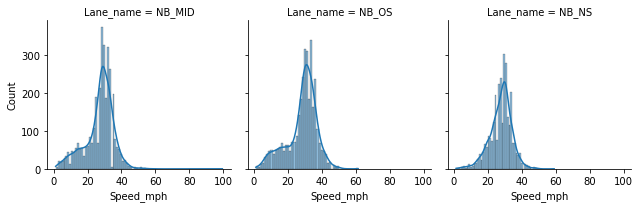

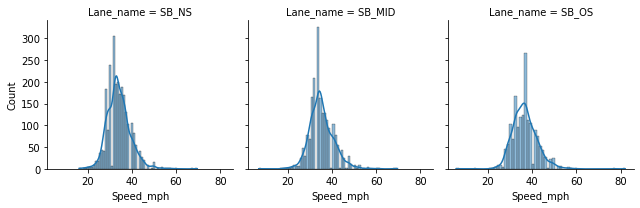

In [414]:
""" Preparing the data for visual analysis
 Plotting multiple histograms (each for the separate lanes) on  FacetGrid so that it can be easily compared"""
g = sns.FacetGrid(filtered_north,col = 'Lane_name')
g.map(sns.histplot,'Speed_mph',kde=True);

f = sns.FacetGrid(filtered_south,col = 'Lane_name')
f.map(sns.histplot,'Speed_mph',kde=True);

#sns.scatterplot(data=filtered_north, x="Speed_mph", y= "")

Here, we can see a histogram plot for the number of cars travelling at certain speeds. In the north lanes, we can see that there’s a higher volume of cars to the left (lower speeds) than with the soutbound lanes. The southbound lanes are more concentrated to the middle, indicating more consistent speeds (and a less of a range).

# ----------------------------------------------------------------------------------------------------------

# 2. Part V.


The NB middle lanes have a much higher range (for speed) than the NB OS and NS lanes indicating less consistent traffic speeds in the middle nortbound lane. This was in difference to the soutbound lanes, where OS lane had least consistent speeds as it had the highest range. Furthermore a range calculation can tell us whether there are any errors in the data. For example, if we find a speed of 200mph on a 30mph road we know there must be an error with how the sensors collected the data or a random value was entered into the dataset somehow. In our case, the max speed between 9AM - 9:59:59 is 99.4 mph which is quite concerning for that time of the day. We would need to verify whether this is an accurate observation or if the sensor had a fault.

The 3rd quartile tells us the speed at or below which 75% of all vehicles are travelling at. Its safe to say that 75% of all drivers on north lanes drive below 34mph. This is 4mph above the speed limit for built up areas, but is not uncommon during everyday driving.

The interquartile range tells us how much variability there is around the median. With the north lanes, the speeds have a higher variability around the median for all the lanes compared to the south lanes. This further shows us that average traffic speeds vary hugely in the northbound lanes which could be due to cars stuck in traffic travelling at speeds less than 3mph and at times when traffic clears cars can travel at their usual speeds. It's different for the south lanes as there's less volume of traffic and so there'll be almost no cars travelling at 3mph or less.

# -----------------------------------------------------------------------------------------------------------

# 2. Part VI


With further analysis, we could find out at what minute of the hour are cars travelling at speeds of above 40mph and compare it to the volume at that particular minute.

The range is sensitive to outliers and so does not provide an accurate representation of the dataset as it misses out lots of the observations in the dataset. The range does not even tell us the minimum and maximum values of the speed, simply the difference between this.

With the quartiles, we cannot calculate the mean speeds and hence can't calculate the variance. Sure, we have the Interquartile range to measure variability, but because it cannot be mathematically manipulated, interquartile range as a measure of variance has a major drawback.
# ----------------------------------------------------------------------------------------------------------

# 2. Part VII.


Question answered through comments explaining the data preparation steps and reasoning. Can be found throughout the code.
# ----------------------------------------------------------------------------------------------------------

# 2. Part VIII.


- Firstly, to help in measuring execution time of my code, I could've used the timeit function to check how much time each part of the program takes to run.

- I could have optimised my code by defining and using more functions with local variables instead of having too many global variables. For example, when creating the filtered dataframes for north and south lanes, I had to create 4 global variables. I could have made 1 function that'd take in 1 argument (e.g the direction) and output the dataframe for the respective direction.


- To make the for loop part of my code work faster, I could've used list comprehensions instead of appending values to a list. (E.g when I calculated the volume of each lane and appended it to a list).


- To improve memory, I could’ve used more memory efficient data types. For float data types, such as the speed, I could convert it into float32 instead of it being float64 as the 32 bit option uses half the memory than the 64 bit option.


- Additionally, I could’ve only imported the specific rows that I needed in my pipeline as 4 of the columns from the dataset wasn’t used. During import of the data with .read_csv() I could’ve added a usecols parameter and specified the specific columns that were needed. This could reduce the memory that's being used


- When importing modules at the top, to save on memory I couldve imported only the methods/functions that I would be using. Theres no point in importing the full module with 20+ functions when I'm only going to use a few, example: I couldve done from csv import read_csv

# ----------------------------------------------------------------------------------------------------------


# Task 3
# Part I.

In [430]:
"""Obtaining all rows where the time is between 7AM - 23:59:59 using the between_time() function. 
Since I'm using thisI need to set the Date column as the index first. Then I reset the index to 
its default.""" 
df_t= df.set_index('Date').between_time('07:00:00','23:59:59').reset_index()


"""I do some data transformation by grouping hours in the date column and calculate vehicle volume 
per hour - I use the dt.hour method to get the hour out of the datetime object and then group it 
by the hour and flag_text (the weekday). Afterwards, the volume is calculated with .size() and is divided
by the number of weekdays for Tuesday and Friday in the in the month (4 for each). The formation of the
data is changed again (using .unstack) so that it can meet analytics requirements (for easy csv conversion 
and graphing capabilities)."""

vol= (df_t.groupby([df_t['Date'].dt.hour,'Flag_text']).size()/4).unstack(level=1).reset_index()
# Now the data is in a format that we can easily visualise or export

# Renaming the column 'Date' to 'Time'
avg_vol= vol.rename(columns={'Date': 'Time'})

# Since I can't remove an index, it will be hidden to make the table look more neat.
avg_vol.style.hide_index().format('{:.2f}').set_caption('The average traffic volume per hour of the day')


Time,Friday,Tuesday
7.00,4806.25,4966.50
8.00,4773.00,4862.00
9.00,3896.75,3978.50
10.00,3284.50,3178.75
11.00,3517.75,3177.75
12.00,3869.25,3408.00
13.00,3949.50,3457.00
14.00,4206.75,3634.00
15.00,4669.00,4286.75
16.00,5362.00,5430.25


The average traffic volume per hour of the day for Tuesday and Friday where 7:00 is the 7th hour (7:00:00-7:59:59) and 23:00 is the 23rd hour (23:00:00-23:59:59)

## 3. Part II.

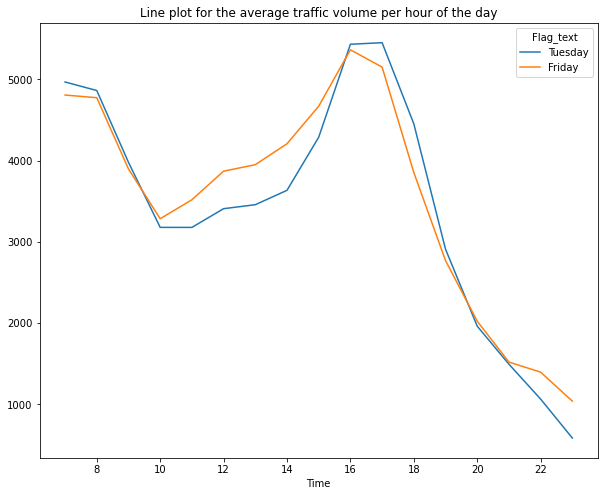

In [384]:
"""Now, some data profiling in the form of visualisations"""

# Plotting a line plot for the average traffic volume per hour of the day for both Tuesday and Friday
avg_vol.plot(y=["Tuesday","Friday"], x="Time", kind="line", figsize=(10, 8),
             title='Line plot for the average traffic volume per hour of the day');


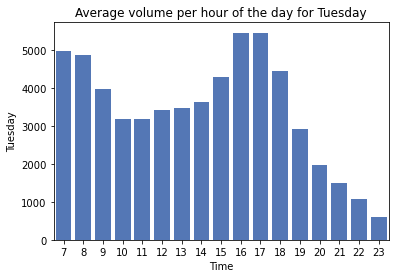

In [379]:
# Creating a barchart for the per hour average volume for Tuesdays
ax = sns.barplot(data=avg_vol,x="Time",y="Tuesday", color='#4473C5');
ax.set_title('Average volume per hour of the day for Tuesday');

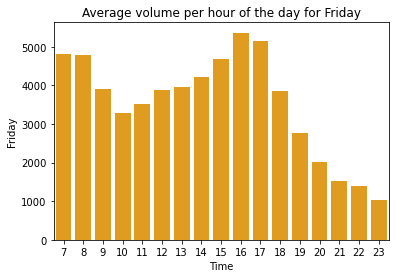

In [380]:
# Creating a barchart for the per hour average volume for Fridays
ax1 = sns.barplot(data=avg_vol,x="Time",y="Friday", color='#FFA500');
ax1.set_title('Average volume per hour of the day for Friday');


#### Tuesdays traffic volume analysis
The average traffic volume for Tuesday is its highest during 5-6pm which is expected as its rush hour. We can note that it is not equivalent to the traffic volume in the morning rush hour (8-9am). Infact the local maximum for the morning rush hours is between 7-8am
We can propose that people come into work/school at staggered times e.g between the times of 7 - 10am, whereas people travel home more or less at the same time (5-6) during the evening rush hours. 
The 23rd hour showed the least amount of volume. This comes at no surprise, however its interesting to note that on Friday, the volumes at the 22nd and 23rd hour of the day are higher than Tuesdays for the same time. This is probably due to people going out on Friday nights as its the end of the week.

#### Fridays traffic volume analysis
On Friday, the busiest time of the day was between 4-5pm, indicating people leaving their work places earlier than usual (like on Tuesday). The local maxima still seems to be 7-8am for the morning rush hours. In the mornings, the least busiest hour is 10-11am

#### Evaluation and comparison between the 2 days
When the day starts (at 7) the traffic volume is higher on Tuesdays than on Fridays. This changes at 10am when the traffic volume for Tuesdays dips below the volume we see for Fridays.
Fridays traffic volume then stays higher than Tuesdays until 4pm, when the volume increases and stays pretty much the same level between 4-5:30pm. Both of the days traffic volumes drop significantly after 6pm. One interesting observation to note is how the traffic volume is higher for Fridays during non-rush hours than Tuesdays' non-rush hours, but in the rush hours, Tuesdays average traffic volume comes out on top. The average volume per hour has less of a range on Fridays than on Tuesdays. We can also observe through the barcharts how the Fridays traffic volume is more consistent throughout the day than Tuesdays.

# 3. Part III.

- On top of calculating the mean (average) a novice data analyst could also calculate the median of the volume.
The median would be useful as it is not affected by extreme values, such as the range is. It provides us a measure of the centre of the volume data. A data analyst can use it in combination with the mean to get an idea of the distribution of the volumes per hour. For example, if it is found that the median is almost the same as the mean, then it can be said that the volumes in the dataset are roughly distributed evenly from the lowest volume to the greatest volume.



- The median can be compared for both of the days to check on which day the traffic volume is most evenly distributed. As it stands currently, just by visualising we can see that the volume on Friday seems to be more evenly distributed, but it'd be good to have it actually calculated.


- The mode could also be calculated, although since there are pretty much 0 chance of there being exactly the same volume in a particular hour, a range of volumes can be made and then a mode can be calculated to see which range of volumes is the most common. For example there can be a range between 20000 - 21000 and it can be seen over different days that this range of volume is most common in the hours of 4-6pm.


- Additionally, the standard deviation can also be found out (once the analyst has the mean). This will tell them about how dispersed the data is compared to the mean (average). A low standard deviation will indicate more of the data being clustered near the mean, whereas a high standard deviation will tell us the data is more spread out in relation to the mean. Our observation from part II. (where it was stated that Fridays volume seemed more consistent) can be confirmed if the standard deviation is calculated for both of the days.


# 3. Part IV.
Comments and descriptions about data preparation can be found in this PDF near each line of code